In [1]:
pip install pmdarima


StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 3, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.7 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


# Develop, evaluate, and score a forecasting model for electricity generation

In [2]:
"""
 Introduction

In this notebook, you'll see Microsoft Fabric's end-to-end data science workflow for a forecasting model. This scenario uses the historic sales data to predict the sales for different categories of products at a superstore.

Forecasting is a crucial asset in sales, harnessing historical data and predictive methods to provide insights into future trends. By analyzing past sales, identifying patterns, and learning from consumer behavior, businesses can optimize inventory, production, and marketing strategies. This proactive approach enhances adaptability, responsiveness, and overall performance of businesses in a dynamic marketplace.

The main steps in this notebook are:

1. Load the data
2. Understand and process the data using exploratory data analysis
3. Train a machine learning model using an open source software package called `SARIMAX` and track experiments using MLflow and Fabric Autologging feature
4. Save the final machine learning model and make predictions
5. Demonstrate the model performance via visualizations in Power BI

Thesis

How much fuel generation will occur in the coming months?

"""

StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 4, Finished, Available)

"\n Introduction\n\nIn this notebook, you'll see Microsoft Fabric's end-to-end data science workflow for a forecasting model. This scenario uses the historic sales data to predict the sales for different categories of products at a superstore.\n\nForecasting is a crucial asset in sales, harnessing historical data and predictive methods to provide insights into future trends. By analyzing past sales, identifying patterns, and learning from consumer behavior, businesses can optimize inventory, production, and marketing strategies. This proactive approach enhances adaptability, responsiveness, and overall performance of businesses in a dynamic marketplace.\n\nThe main steps in this notebook are:\n\n1. Load the data\n2. Understand and process the data using exploratory data analysis\n3. Train a machine learning model using an open source software package called `SARIMAX` and track experiments using MLflow and Fabric Autologging feature\n4. Save the final machine learning model and make pre

# Libraries and Variables

In [3]:
# Importing required libraries
import warnings
import itertools
# Record the notebook running time
import time
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
# Set up MLflow for experiment tracking
import mlflow
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import pmdarima as pm
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
# Import required libraries for model evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pyspark.sql.functions import col, to_date
from pmdarima.arima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
import os, requests
import statsmodels.api as sm
"""
`Statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models
It also allows you to conduct statistical tests and statistical data exploration.
"""

StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 5, Finished, Available)

'\n`Statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models\nIt also allows you to conduct statistical tests and statistical data exploration.\n'

In [4]:
"""
Define Variables
"""

EXPERIMENT_NAME = "EIA-predictions"  # MLflow experiment name

ts = time.time()

"""
ML Flow: Machine Learning

Autologging in Microsoft Fabric extends the MLflow autologging capabilities by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to the workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in the workspace. To learn more about autologging, see [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).
"""

mlflow.set_experiment(EXPERIMENT_NAME)
# mlflow.autolog(disable=True)  # Disable MLflow autologging
mlflow.autolog(disable=False)  # Enable MLflow autologging


StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 6, Finished, Available)

2023/12/15 21:07:27 INFO mlflow.tracking.fluent: Experiment with name 'EIA-predictions' does not exist. Creating a new experiment.
2023/12/15 21:07:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/15 21:07:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


# Step 1: Datasets

### Training and Testing Data

In [5]:
"""
Step 1: Read the dataset from the lakehouse
"""

df = spark.sql(
"""
SELECT 
Type.FuelClass Fuel_class
,Ops.OperatingDate Operating_date
,sum(Fact.NetGenerationElectricityMWh) Electricity_generated
FROM EIA_Lake.fact_generation Fact
left outer join dim_fuel_type Type on Fact.FuelTypeKey = Type.FuelTypeKey
left outer join dim_plant Ops on Fact.PlantKey = Ops.PlantKey 
where Ops.OperatingDate > '1999-12-31'
GROUP BY 
Type.FuelClass 
,Ops.OperatingDate 
"""
)

Training_data = df

"""
Data Reformatting
"""
Training_data = Training_data.withColumnRenamed("Fuel_Class", "Fuel class")
Training_data = Training_data.withColumnRenamed("Operating_Date", "Operating date")
Training_data = Training_data.withColumnRenamed("Electricity_Generated", "Electricity generated")
Training_data = Training_data.withColumn("Operating date", to_date(col("Operating date")))
# Convert the PySpark DataFrame to a Pandas DataFrame
Training_data = Training_data.toPandas()

"""
How to specify or convert the data types post-conversion in the Pandas DataFrame
"""

# Assuming Training_data is your Pandas DataFrame
Training_data['Fuel class'] = Training_data['Fuel class'].astype(str)
# Assuming Training_data is your Pandas DataFrame
Training_data['Operating date'] = pd.to_datetime(Training_data['Operating date'])
# Convert the 'Electricity generated' column to int
Training_data['Electricity generated'] = Training_data['Electricity generated'].astype(int)

"""
The dataset is structured on a daily basis
The goal is to develop a model to forecast the sales on a monthly basis, you need to resample on the column `Order Date`.

1. group the `Furniture` category by `Order Date` and then 
2. calculate the sum of the `Sales` column for each group in order to determine the total sales for each unique `Order Date`. 
3. resample the `Sales` column using the `MS` frequency to aggregate the data by month and then you calculate the mean sales value for each month.
"""

# Data preprocessing
Training_data = Training_data.sort_values('Operating date')
Training_data.isnull().sum()
Training_data = Training_data.groupby('Operating date')['Electricity generated'].sum().reset_index()
Training_data = Training_data.set_index('Operating date')
y = Training_data['Electricity generated'].resample('MS').mean()
y = y.fillna(0) # Fill NaN values with zero
y = y.astype('int64')
y = y.reset_index()
y['Operating date'] = pd.to_datetime(y['Operating date'])
test_data = y[y['Operating date'].dt.strftime('%Y-%m-%d') > "2021-06-01"] # testing data
test_data = test_data[test_data['Operating date'].dt.strftime('%Y-%m-%d') < "2023-01-01"] # testing data
test_data = test_data.set_index(['Operating date'])
display(test_data)
y = y[y['Operating date'].dt.strftime('%Y-%m-%d') < "2022-01-01"] # training data
y = y.set_index(['Operating date'])
maximim_date = y.reset_index()['Operating date'].max()
display(y)



StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 7, Finished, Available)

SynapseWidget(Synapse.DataFrame, c0859edc-6d35-401e-88e1-7f6ec5233253)

SynapseWidget(Synapse.DataFrame, ee9b59dc-cca9-41a8-9944-c449245b1810)

### Validation Data

In [6]:
"""
Step 1: Read the dataset from the lakehouse
"""

df = spark.sql(
"""
SELECT 
Type.FuelClass Fuel_class
,Ops.OperatingDate Operating_date
,sum(Fact.NetGenerationElectricityMWh) Electricity_generated
FROM EIA_Lake.fact_generation Fact
left outer join dim_fuel_type Type on Fact.FuelTypeKey = Type.FuelTypeKey
left outer join dim_plant Ops on Fact.PlantKey = Ops.PlantKey 
where Ops.OperatingDate > '2021-06-30' and Ops.OperatingDate < '2023-01-01'
GROUP BY 
Type.FuelClass 
,Ops.OperatingDate 
"""
)

validation_data = df

"""
Data Reformatting
"""
validation_data = validation_data.withColumnRenamed("Fuel_Class", "Fuel class")
validation_data = validation_data.withColumnRenamed("Operating_Date", "Operating date")
validation_data = validation_data.withColumnRenamed("Electricity_Generated", "Electricity generated")
validation_data = validation_data.withColumn("Operating date", to_date(col("Operating date")))
# Convert the PySpark DataFrame to a Pandas DataFrame
validation_data = validation_data.toPandas()

"""
How to specify or convert the data types post-conversion in the Pandas DataFrame
"""

# Assuming validation_data is your Pandas DataFrame
validation_data['Fuel class'] = validation_data['Fuel class'].astype(str)
# Assuming validation_data is your Pandas DataFrame
validation_data['Operating date'] = pd.to_datetime(validation_data['Operating date'])
# Convert the 'Electricity generated' column to int
validation_data['Electricity generated'] = validation_data['Electricity generated'].astype(int)

# Data preprocessing
validation_data = validation_data.sort_values('Operating date')
validation_data.isnull().sum()
validation_data = validation_data.groupby('Operating date')['Electricity generated'].sum().reset_index()
validation_data = validation_data.set_index('Operating date')
validation_data = validation_data['Electricity generated'].resample('MS').mean()
validation_data = validation_data.fillna(0) # Fill NaN values with zero
validation_data = validation_data.astype('int64')
validation_data = validation_data.reset_index()
validation_data['Operating date'] = pd.to_datetime(validation_data['Operating date'])
display(validation_data)

StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 8, Finished, Available)

SynapseWidget(Synapse.DataFrame, 21fd9915-ba1a-44ef-a95c-03d3ac2052ad)

# Step 2: Statistical Analysis

StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 9, Finished, Available)

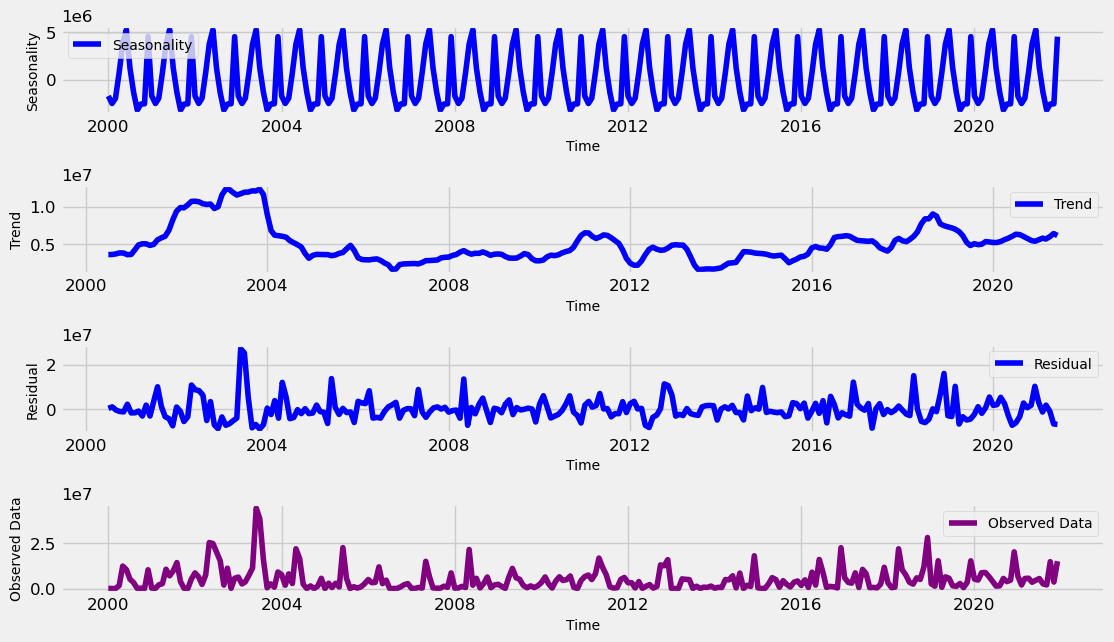

'\nDoing time series analysis. We are preforming seasonal decomposition. This gives an overall understanding of how these components contribute to the entire time series.\nUnderstanding the seasonality, trend, and noise in the forecasting data through the above plots allows to capture underlying patterns, and develop models that make more accurate predictions that are resilient to random fluctuations.\n'

In [7]:
"""
Statistical analysis

A time series tracks four data elements at set intervals in order to determine the variation of those four elements in the time series pattern. These elements include:

- **Level:** Refers to the fundamental component that represents the average value for a specific time period.

- **Trend:** Describes whether the time series is decreasing, constant, or increasing over time.

- **Seasonality:** Describes the periodic signal in the time series and looks for cyclic occurrences that affect the time series' increasing or decreasing patterns.

- **Noise/Residual:** Refers to the random fluctuations and variability in the time series data that cannot be explained by the model.

In the following, you will observe the above four components for your dataset after the pre-processing.
"""

# Decompose the time series into its components using statsmodels
result = sm.tsa.seasonal_decompose(y, model='additive')

# Labels and corresponding data for plotting
components = [('Seasonality', result.seasonal),
              ('Trend', result.trend),
              ('Residual', result.resid),
              ('Observed Data', y)]

# Create subplots in a grid
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.8)  # Adjust vertical space
axes = axes.ravel()

# Plot the components
for ax, (label, data) in zip(axes, components):
    ax.plot(data, label=label, color='blue' if label != 'Observed Data' else 'purple')
    ax.set_xlabel('Time')
    ax.set_ylabel(label)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel(label, fontsize=10)
    ax.legend(fontsize=10)

plt.show()

"""
Doing time series analysis. We are preforming seasonal decomposition. This gives an overall understanding of how these components contribute to the entire time series.
Understanding the seasonality, trend, and noise in the forecasting data through the above plots allows to capture underlying patterns, and develop models that make more accurate predictions that are resilient to random fluctuations.
"""

In [8]:
"""
Statistical Measure of accuracy
"""
def mean_absolute_error(y_true, y_pred):
    """
    Calculate Mean Absolute Error (MAE)
    
    Args:
    y_true: List or array containing true values
    y_pred: List or array containing predicted values
    
    Returns:
    mae: Mean Absolute Error
    """
    if len(y_true) != len(y_pred):
        raise ValueError("Lengths of y_true and y_pred must be the same.")
    
    total_error = 0
    for true_val, pred_val in zip(y_true, y_pred):
        total_error += abs(true_val - pred_val)
    
    mae = total_error / len(y_true)
    return mae

StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 10, Finished, Available)

# Step 3: Model Training and Tracking

With your data in place, you can define the forecasting model. Apply the Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) in this notebook. SARIMAX is a time series forecasting model that extends SARIMA to include exogenous variables. It combines autoregressive (AR) and moving average (MA) components, seasonal differencing, and external predictors to make accurate and flexible forecasts for time series data, making it a powerful tool for various forecasting tasks.

You will also use MLfLow and Fabric Autologging to track the experiments. Here you'll load the delta table from the lakehouse. You may use other delta tables considering the lakehouse as the source.

"""
SARIMAX, or Seasonal Autoregressive Integrated Moving Average with Exogenous Factors, 
a time series forecasting method that extends the traditional ARIMA model to include seasonal components and exogenous variables. 

The acronym breaks down as follows:
- Seasonal: Accounts for patterns that repeat over known intervals or seasons.
- ARIMA: Stands for Autoregressive Integrated Moving Average, a model used for understanding and forecasting time series data.
- X: Denotes the inclusion of exogenous variables, which are external factors that can influence the time series being forecasted.

In SARIMAX models, the seasonal and non-seasonal components of the time series data are modeled separately. 
It's a powerful tool for handling time series data that exhibits both seasonal patterns and relationships with other variables.
It's often used
"""

### Hyperparameter tuning

SARIMAX takes into account the parameters involved in regular ARIMA mode `(p,d,q)` and also adds the seasonality parameters `(P,D,Q,s)`. These arguments to SARIMAX model are called order `(p,d,q)` and seasonal order `(P,D,Q,s)` respectively and hence 7 parameters to tune. Prior to model training, you need to set up these parameters which are defined in the following.

#### Order Parameters `(p, d, q)`:
- `p`: The order of the autoregressive (AR) component, indicating how many past observations are considered. It is also known as the AR order.
- `d`: The degree of differencing required to make the time series stationary. It is also known as the differencing order.
- `q`: The order of the moving average (MA) component, indicating how many past white noise error terms are considered. It is also known as the MA order.

#### Seasonal Order Parameters `(P, D, Q, s)`:

- `P`: The seasonal order of the autoregressive (AR) component, similar to `p` but for the seasonal part.
- `D`: The seasonal order of differencing, similar to `d` but for the seasonal part.
- `Q`: The seasonal order of the moving average (MA) component, similar to `q` but for the seasonal part.
- `s`: The number of time steps per seasonal cycle (e.g., 12 for monthly data with a yearly seasonality).


 The autoregressive order `p` represents the number of past observations in the time series that are used to predict the current value. Typically, `p` should be a non-negative integer. Common values for `p` are usually in the range of 0 to 3, although higher values are possible depending on the specific characteristics of the data. A higher p indicates a longer memory of past values in the model.

 The moving average order `q` represents the number of past white noise error terms that are used to predict the current value. Similar to `p`, `q` should also be a non-negative integer. Common values for `q` are typically in the range of 0 to 3, but higher values may be necessary for certain time series. A higher `q` indicates a stronger reliance on past error terms to make predictions.

 The differencing order `d` represents the number of times the time series needs to be differenced to achieve stationarity. `d` should be a non-negative integer. Common values for `d` are usually in the range of 0 to 2. A `d` value of 0 means the time series is already stationary, while higher values indicate the number of differencing operations required to make it stationary.


#### Determine Optional Parameters:
- The `enforce_stationarity` parameter controls whether or not the model should enforce stationarity on the time series data before fitting the SARIMAX model. When `enforce_stationarity` is set to `True` (the default), it indicates that the SARIMAX model should enforce stationarity on the time series data. This means that the SARIMAX model will automatically apply differencing to the data to make it stationary, as specified by the `d` and `D` orders, before fitting the model. This is a common practice because many time series models, including SARIMAX, assume that the data is stationary. If your time series is non-stationary (e.g., it exhibits trends or seasonality), it is generally a good practice to set `enforce_stationarity` to `True` and let the SARIMAX model handle the differencing to achieve stationarity. If your time series is already stationary (e.g., it has no trends or seasonality), you can set `enforce_stationarity` to `False` to avoid unnecessary differencing.

- The `enforce_invertibility` parameter controls whether or not the model should enforce invertibility on the estimated parameters during the optimization process. When `enforce_invertibility` is set to `True` (the default), it indicates that the SARIMAX model should enforce invertibility on the estimated parameters. Invertibility ensures that the model is well-defined and that the estimated autoregressive (AR) and moving average (MA) coefficients are within the range of stationarity. Enforcing invertibility is typically recommended to ensure that the SARIMAX model adheres to the theoretical requirements for a stable time series model and helps prevent issues with model estimation and stability.

- The default is an `AR(1)` model which refers to `(1,0,0)`. However, keep in mind that the appropriate values for `p`, `q`, and `d` can vary from one time series to another, and determining the optimal values often involves analyzing the autocorrelation and partial autocorrelation functions (ACF and PACF) of the time series data and using model selection criteria like AIC or BIC. It's common practice to try different combinations of p, q, and d and evaluate the model's performance for a given dataset. Note that the parameters for the seasonal order `(P, D, Q, s)` is similar in concept to the non-seasonal order parameters `(p, q, d)`, hence it is avoided explaining in detail again. 

In [9]:
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

# Call the function with your time series data 'y'
check_stationarity(y)


StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 11, Finished, Available)

2023/12/15 21:07:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9c9f953f-1025-4e9e-b2f6-12b1df052ac3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:08:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b0d38b24-e5af-402b-929d-a8389668a9c9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:08:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ce9ff24f-7b2b-4991-bdbf-52cee4af6b11', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:08:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2a05409b-659e-4919-a822-cfae0f87c0b7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:08:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5aed7faa-f6ca-4cee-a676-200f78349e40', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:08:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5459fb76-07b5-498a-8b72-ddb226564046', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:08:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '70e8a7fc-ac13-45ef-961c-a67765fc0819', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:08:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b327f27b-3daf-427a-8714-3663d6784fa8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:08:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c7a7f272-1d00-4817-801f-0c0d3815f942', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:08:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e5cbddb7-6a67-47f4-8b4d-37744f246e38', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:08:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7796b713-967a-42a3-a57a-b466fd11170b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:08:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6a1280ed-aaf5-4ab3-a231-9db0e564ecd5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:09:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2ec4e609-2d6d-463a-a533-8b3fa1053e66', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:09:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '84faf7b0-e1fa-4879-b667-01dc5206d451', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:09:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '92bf7556-81e7-4d1d-9327-cadcc6efad10', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:09:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '52b2dc69-c390-4bc5-9fed-b1f13b49cce0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:09:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7f4b03c9-9fd7-4e98-80bd-1d04d7784d17', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:09:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '512b58b2-a8b2-4fdd-adad-d12d9397a5d1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


ADF Statistic: -2.3194042206763066
p-value: 0.16578607219229974
Critical Values:
	1%: -3.4565688966099373
	5%: -2.8730786194395455
	10%: -2.5729189953388762
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Find Difference Values

StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 12, Finished, Available)

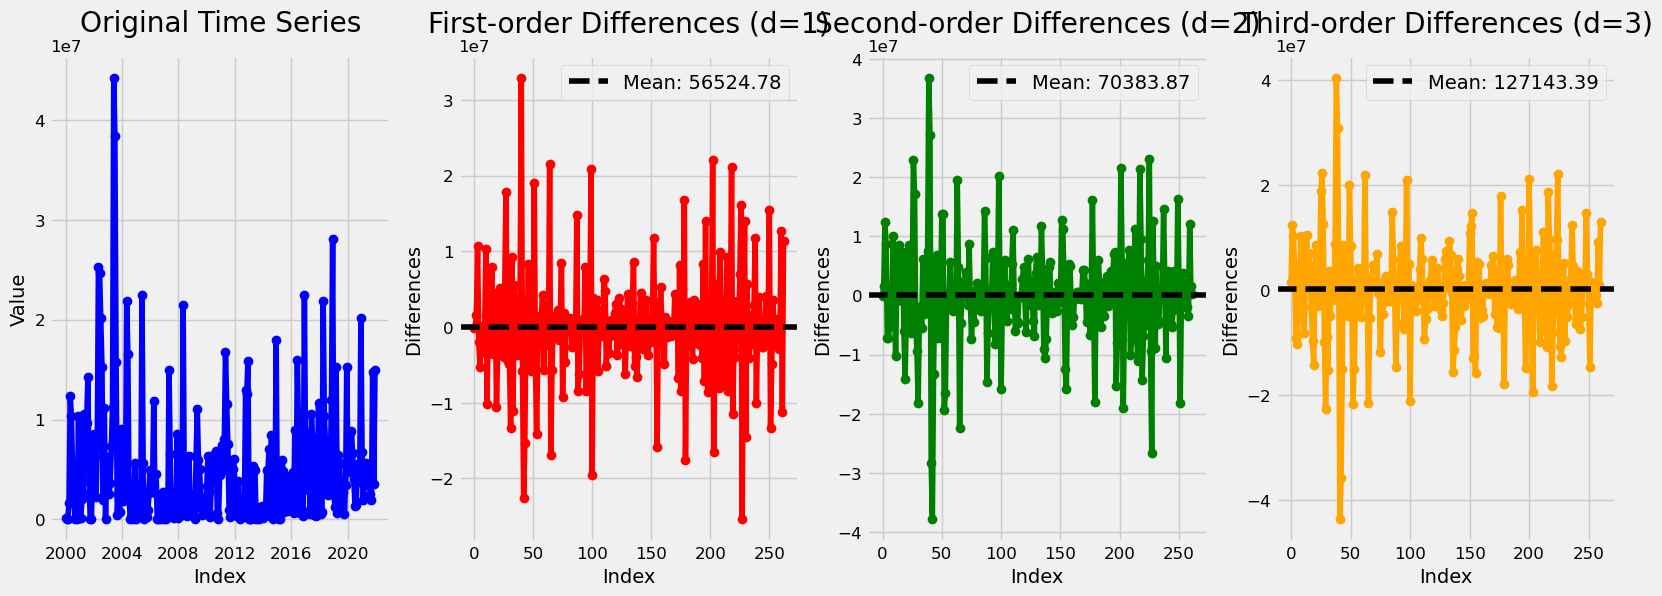

In [10]:

# Original time series data
original_data = y['Electricity generated']

# First-order differences
first_differences = [original_data[i] - original_data[i - 1] for i in range(1, len(original_data))]

# Second-order differences
second_differences = [original_data[i] - original_data[i - 2] for i in range(2, len(original_data))]

# Third-order differences
third_differences = [original_data[i] - original_data[i - 3] for i in range(3, len(original_data))]

# Calculating means for each differenced series
first_diff_mean = np.mean(first_differences)
second_diff_mean = np.mean(second_differences)
third_diff_mean = np.mean(third_differences)

# Plotting the original data
plt.figure(figsize=(18, 6))

# Plotting the original data
plt.subplot(141)
plt.plot(original_data, marker='o', color='blue')
plt.title('Original Time Series')
plt.xlabel('Index')
plt.ylabel('Value')

# Plotting the first-order differences
plt.subplot(142)
plt.plot(first_differences, marker='o', color='red')
plt.axhline(y=first_diff_mean, color='black', linestyle='--', label=f'Mean: {first_diff_mean:.2f}')
plt.title('First-order Differences (d=1)')
plt.xlabel('Index')
plt.ylabel('Differences')
plt.legend()

# Plotting the second-order differences
plt.subplot(143)
plt.plot(second_differences, marker='o', color='green')
plt.axhline(y=second_diff_mean, color='black', linestyle='--', label=f'Mean: {second_diff_mean:.2f}')
plt.title('Second-order Differences (d=2)')
plt.xlabel('Index')
plt.ylabel('Differences')
plt.legend()

# Plotting the third-order differences
plt.subplot(144)
plt.plot(third_differences, marker='o', color='orange')
plt.axhline(y=third_diff_mean, color='black', linestyle='--', label=f'Mean: {third_diff_mean:.2f}')
plt.title('Third-order Differences (d=3)')
plt.xlabel('Index')
plt.ylabel('Differences')
plt.legend()
plt.show()




StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 13, Finished, Available)

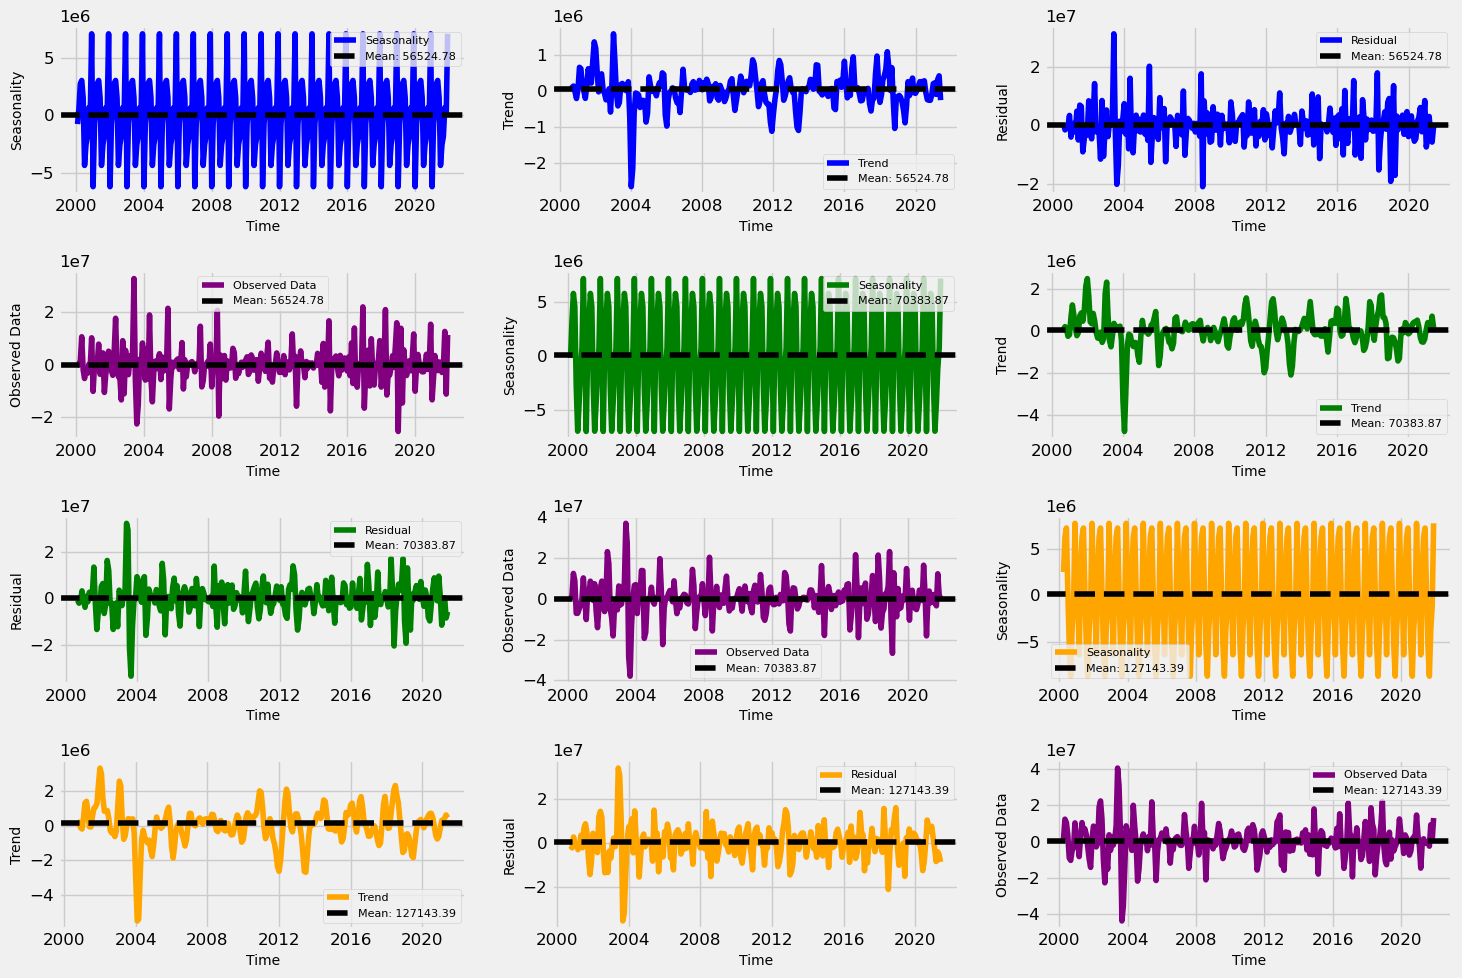

In [11]:
# Assuming 'first_differences', 'second_differences', 'third_differences' contain the respective differenced series

# Create timestamp indices for the differenced series (assuming monthly data)
start_date = pd.to_datetime('2000-03-01')
end_date = pd.to_datetime('2021-12-01')  # Adjust based on your data length
timestamp1 = pd.date_range(start=pd.to_datetime('2000-01-01'), end=end_date, freq='M')
timestamp2 = pd.date_range(start=pd.to_datetime('2000-02-01'), end=end_date, freq='M')
timestamp3 = pd.date_range(start=pd.to_datetime('2000-03-01'), end=end_date, freq='M')
# Create pandas Series with timestamps for each differenced series
differenced_series1 = pd.Series(first_differences, index=timestamp1)
differenced_series2 = pd.Series(second_differences, index=timestamp2)
differenced_series3 = pd.Series(third_differences, index=timestamp3)

# Calculating means for each differenced series
first_diff_mean = np.mean(differenced_series1)
second_diff_mean = np.mean(differenced_series2)
third_diff_mean = np.mean(differenced_series3)

# Decompose each time series into its components using statsmodels
result1 = sm.tsa.seasonal_decompose(differenced_series1, model='additive')
result2 = sm.tsa.seasonal_decompose(differenced_series2, model='additive')
result3 = sm.tsa.seasonal_decompose(differenced_series3, model='additive')

# Labels and corresponding data for plotting for each series
components1 = [('Seasonality', result1.seasonal),
               ('Trend', result1.trend),
               ('Residual', result1.resid),
               ('Observed Data', differenced_series1)]

components2 = [('Seasonality', result2.seasonal),
               ('Trend', result2.trend),
               ('Residual', result2.resid),
               ('Observed Data', differenced_series2)]

components3 = [('Seasonality', result3.seasonal),
               ('Trend', result3.trend),
               ('Residual', result3.resid),
               ('Observed Data', differenced_series3)]

# Create subplots in a grid for each series
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.8)  # Adjust vertical space
axes = axes.ravel()

# Plot the components for each series
for i, (label, data) in enumerate(components1):
    ax = axes[i]
    ax.plot(data, label=label, color='blue' if label != 'Observed Data' else 'purple')
    ax.axhline(y=first_diff_mean, color='black', linestyle='--', label=f'Mean: {first_diff_mean:.2f}')
    ax.set_xlabel('Time')
    ax.set_ylabel(label)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel(label, fontsize=10)
    ax.legend(fontsize=8)

for i, (label, data) in enumerate(components2):
    ax = axes[i + 4]
    ax.plot(data, label=label, color='green' if label != 'Observed Data' else 'purple')
    ax.axhline(y=second_diff_mean, color='black', linestyle='--', label=f'Mean: {second_diff_mean:.2f}')
    ax.set_xlabel('Time')
    ax.set_ylabel(label)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel(label, fontsize=10)
    ax.legend(fontsize=8)

for i, (label, data) in enumerate(components3):
    ax = axes[i + 8]
    ax.plot(data, label=label, color='orange' if label != 'Observed Data' else 'purple')
    ax.axhline(y=third_diff_mean, color='black', linestyle='--', label=f'Mean: {third_diff_mean:.2f}')
    ax.set_xlabel('Time')
    ax.set_ylabel(label)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel(label, fontsize=10)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [12]:
check_stationarity(differenced_series1)

StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 14, Finished, Available)

2023/12/15 21:09:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e3e49fa3-b1a2-43f4-95c4-897fefe10ed2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:09:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8603e138-8128-44df-9130-c2857c1e3df1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:09:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5f9b90ea-f04b-4636-9aaf-b8788c3bc866', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:09:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '048615bd-8966-4254-8753-de87d549cf1b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:09:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dce0f583-3c9c-4628-9cf9-d406a979d870', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:10:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2cc02e50-d9d8-459f-917d-ded93f68e1ba', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:10:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'caa4852a-98c2-46b0-89aa-268088fbcf4a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:10:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4eb96e46-c7c0-465f-a320-a14e4a147a8b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:10:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6855da47-c2ef-41f7-aa24-eec14be04276', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:10:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dae36150-1612-4bf9-9e22-46fbbaba5597', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:10:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c1efdd90-c6cf-4bec-b607-bd5283ab6cc3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:10:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7f88d3c9-b216-462f-b0f6-7073622713a1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:10:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '909949be-5446-4cad-8ca9-10baddc6c933', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:10:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '28cfd780-b5cd-4ab7-b010-ac559e151b6f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:10:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c6fd7724-d796-4f7c-8e79-225901429722', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:10:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a006241d-8087-4956-af70-c53078d1605f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:10:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ce02e8f4-51ad-442f-975f-fcbdbb36c0f7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/12/15 21:11:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4af0c395-bd04-4f28-b8c4-faa8da9bba16', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


ADF Statistic: -12.504184629075908
p-value: 2.7639144754029624e-23
Critical Values:
	1%: -3.4565688966099373
	5%: -2.8730786194395455
	10%: -2.5729189953388762
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


#### Grid search method.

In [14]:
# Grid search method.
"""
The auto_arima function itself operates a bit like a grid search, 
in that it tries various sets of p and q (also P and Q for seasonal models) parameters, 
selecting the model that minimizes the AIC (or BIC, or whatever information criterion you select). 
To select the differencing terms, auto_arima uses a test of stationarity (such as an augmented Dickey-Fuller test)
 and seasonality (such as the Canova-Hansen test) for seasonal models.
 """



# fit stepwise auto-ARIMA
stepwise_fit = pm.auto_arima(y, start_p=1, start_q=1,
                             max_p=6, max_q=6, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise


StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 16, Finished, Available)

Performing stepwise search to minimize aic


2023/12/15 21:34:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fadcbe21-ad8a-4387-9adc-4114524657cc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=8549.904, Time=9.39 sec


2023/12/15 21:34:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '533b6283-4355-49ee-a9d6-80b641c3e2dd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,0)(0,1,0)[12]             : AIC=8716.551, Time=4.82 sec


2023/12/15 21:34:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9022f95e-8ac5-42b3-990f-c4cae5e9b9ef', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8616.398, Time=4.96 sec


2023/12/15 21:34:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1afa215f-7386-4686-8847-bff6499c996c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=8557.136, Time=4.95 sec


2023/12/15 21:34:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '35b0e5db-31d7-4605-a9fa-6dbb937aec8e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=4.57 sec


2023/12/15 21:34:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'db0e4260-5cd3-42c2-8831-71baaa60e84f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,1)(1,1,1)[12]             : AIC=8551.859, Time=5.11 sec


2023/12/15 21:34:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8bdc16b3-8241-44e3-b324-d38f475690e4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=8551.872, Time=5.78 sec


2023/12/15 21:34:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b8d6b5ba-ccf0-47ff-965b-bbc38c675292', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=8565.207, Time=5.16 sec


2023/12/15 21:34:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5e033e6e-ec80-4279-9937-f8895b7b97dd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,1)(1,1,2)[12]             : AIC=8552.716, Time=6.27 sec


2023/12/15 21:35:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8fcab719-876c-450a-94b2-4be3e4708d2c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,0)(0,1,1)[12]             : AIC=8593.780, Time=5.72 sec


2023/12/15 21:35:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '01a19624-243c-46b2-9bb6-3c618e41504f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(2,1,1)(0,1,1)[12]             : AIC=8551.303, Time=5.95 sec


2023/12/15 21:35:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fe893ce1-bb25-422c-83d1-1949471783a9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,2)(0,1,1)[12]             : AIC=8542.766, Time=6.49 sec


2023/12/15 21:35:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd0c6779b-fc6f-4061-a992-8723502f2a1a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=4.91 sec


2023/12/15 21:35:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b23cc9dc-d7d9-4b24-a28b-e7cb44fa7234', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,2)(1,1,1)[12]             : AIC=8544.696, Time=5.45 sec


2023/12/15 21:35:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '078810b4-ce30-4d7d-b36f-7c62755324c5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,2)(0,1,2)[12]             : AIC=8544.717, Time=5.99 sec


2023/12/15 21:35:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '93ced0fd-619c-4569-934f-d18cfb270850', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,2)(1,1,0)[12]             : AIC=8559.720, Time=5.27 sec


2023/12/15 21:35:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9b7e0cdb-36ed-4e72-b1c8-e21076ea05b5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,2)(1,1,2)[12]             : AIC=8545.513, Time=6.97 sec


2023/12/15 21:35:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e853f9b0-7f27-4bee-b5b2-d9a7bc9d5027', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,2)(0,1,1)[12]             : AIC=8541.259, Time=5.09 sec


2023/12/15 21:35:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'def4a20f-f4b0-4bf2-9dd9-58c38b4a0abc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,2)(0,1,0)[12]             : AIC=inf, Time=4.74 sec


2023/12/15 21:35:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e0a0fda1-0a15-422f-9f7a-60170f259e7d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,2)(1,1,1)[12]             : AIC=8543.184, Time=5.39 sec


2023/12/15 21:36:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a6c36c42-2762-499c-888a-9796d1f79cc7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,2)(0,1,2)[12]             : AIC=8543.207, Time=5.83 sec


2023/12/15 21:36:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3aeed34e-f005-4828-a325-08713edc1eb1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,2)(1,1,0)[12]             : AIC=8557.979, Time=5.20 sec


2023/12/15 21:36:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '036fc059-0ccf-42d6-8be4-c1d3a508227b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,2)(1,1,2)[12]             : AIC=8543.978, Time=5.90 sec


2023/12/15 21:36:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '66b6fe24-a82c-4fb9-a1a7-4730a550676d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,3)(0,1,1)[12]             : AIC=8539.752, Time=5.28 sec


2023/12/15 21:36:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b023f8bc-ba25-4c68-a854-b166addbd945', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,3)(0,1,0)[12]             : AIC=inf, Time=4.77 sec


2023/12/15 21:36:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b9453024-bcc9-4e93-bc1a-3e782dfebf4e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,3)(1,1,1)[12]             : AIC=8541.676, Time=5.19 sec


2023/12/15 21:36:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f8114210-3e8e-485a-a9f9-fc78b5f709bd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,3)(0,1,2)[12]             : AIC=8541.699, Time=6.10 sec


2023/12/15 21:36:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd6404f3e-cfb7-47bb-9c8d-c8205df6b296', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,3)(1,1,0)[12]             : AIC=8557.355, Time=5.17 sec


2023/12/15 21:36:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8d40f8c1-6889-4c5f-a46a-086ba26bc3d1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,3)(1,1,2)[12]             : AIC=8542.475, Time=6.66 sec


2023/12/15 21:36:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b431bb56-5951-438c-a257-e53df33c5103', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,3)(0,1,1)[12]             : AIC=8540.015, Time=5.38 sec


2023/12/15 21:37:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c4590cef-2080-48c4-95d0-9e094eeaa563', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,4)(0,1,1)[12]             : AIC=8540.016, Time=5.26 sec


2023/12/15 21:37:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '27cfc74f-1355-433a-bfc4-7400f96829d3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(1,1,4)(0,1,1)[12]             : AIC=8540.344, Time=5.81 sec


2023/12/15 21:37:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'efd0ce53-ed5b-499e-997a-2b69c4f0e67e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


 ARIMA(0,1,3)(0,1,1)[12] intercept   : AIC=8544.784, Time=5.00 sec

Best model:  ARIMA(0,1,3)(0,1,1)[12]          
Total fit time: 184.554 seconds


In [20]:
# Assuming you have 'stepwise_fit' from your initial grid search
d_value = stepwise_fit.order[1]
D_value = stepwise_fit.seasonal_order[1]


# Fixed values of d and D from the initial grid search
d = d_value
D = D_value

# Define the range for p, P, q, Q
p_values = range(1, 1)
P_values = range(1, 1)
q_values = range(1, 1)
Q_values = range(1, 1)

best_aic = float("inf")
best_order = None
best_seasonal_order = None

# Iterate through the combinations of p, P, q, Q
for p, P, q, Q in itertools.product(p_values, P_values, q_values, Q_values):
    try:
        # Fit SARIMAX model for each combination
            mod = sm.tsa.statespace.SARIMAX(y,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
            results = mod.fit(disp=False)
            # Log SARIMAX model parameters
            mlflow.log_params({"order": (p, d, q), "seasonal_order": (P, D, Q, 12), 'enforce_stationarity': True, 'enforce_invertibility': True})
    except:
        continue



StatementMeta(, d154688c-ba95-4987-bd92-696fa028842d, 22, Submitted, Waiting)

# What I found that works

In [ ]:
"""
p = 7
d = 1
q = 5
P = 1
D = 1
Q = 1
s = 12


# Start an MLflow run
with mlflow.start_run():

    mod = sm.tsa.statespace.SARIMAX(y,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, s),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
    results = mod.fit(disp=False)

    # Calculate predictions
    forecast = results.get_forecast(steps=len(test_data))
    predicted_values = forecast.predicted_mean
    # Extracting true values for the same range
    true_values = test_data  # Corresponding true values for the prediction range


    # Calculate MAPE
    def calculate_mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = calculate_mape(true_values, predicted_values)

    # Log MAPE as a metric
    mlflow.log_metric("MAPE", mape)

    # Log SARIMAX model parameters
    mlflow.log_params({"order": (p, d, q), "seasonal_order": (P, D, Q, s), 'enforce_stationarity': True, 'enforce_invertibility': True})
    


    # # Log the SARIMAX model summary as a text artifact
    # mlflow.log_artifact("model_summary.txt", results.summary().as_text())

# So, because we have actuals, the predications variable allows us to do a predication vs actual comparison. 
predictions = results.get_prediction(start=maximim_date-pd.DateOffset(months=6-1), dynamic=False)

# This initiates the forecast one month after maximim_date and for the next 6 months (months=6)
predictions_future = results.get_prediction(start=maximim_date+ pd.DateOffset(months=1),end=maximim_date+ pd.DateOffset(months=12),dynamic=False)

# This initiates the forecast precisely at maximim_date and for the next 6 months (months=6)
pred = results.get_prediction(start=maximim_date, end=maximim_date+pd.DateOffset(months=6), dynamic=False) 

pred_ci = pred.conf_int() # Extract the confidence intervals for the predictions.
pred_ci_2 = predictions_future.conf_int() # Extract the confidence intervals for the predictions.
# Plot the forecasting results
ax = y['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

predictions_future.predicted_mean.plot(ax=ax, label='Electricity Forecast', alpha=.7, figsize=(12, 7))
ax.fill_between(pred_ci_2.index,
                pred_ci_2.iloc[:, 0],
                pred_ci_2.iloc[:, 1], color='r', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Fuel Generated')
plt.legend()
plt.show()


# Log the model and parameters
model_name = f"{EXPERIMENT_NAME}-Sarimax"
with mlflow.start_run(run_name="Sarimax") as run:
    mlflow.statsmodels.log_model(results,model_name,registered_model_name=model_name)
    mlflow.log_params({"order":(p,d,q),"seasonal_order":(P, D, Q, s),'enforce_stationarity':True,'enforce_invertibility':True})
    model_uri = f"runs:/{run.info.run_id}/{model_name}"
    print("Model saved in run %s" % run.info.run_id)
    print(f"Model URI: {model_uri}")
mlflow.end_run()

# Load the saved model
loaded_model = mlflow.statsmodels.load_model(model_uri)

"""

In [ ]:

# Data Preparation for Power BI visualization
Future = pd.DataFrame(predictions_future.predicted_mean).reset_index()
Future.columns = ['Operating date','Forecasted_Electricity']
Forecasted_Actuals = pd.DataFrame(predictions.predicted_mean).reset_index()
Forecasted_Actuals.columns = ['Operating date','Forecasted_Electricity']
Forecasted_data = pd.concat([Forecasted_Actuals,Future])
# Using merge
result = pd.merge(validation_data, Forecasted_data[['Operating date', 'Forecasted_Electricity']], on='Operating date', how='left')
result['Order'] = np.NAN
result = result.fillna('SARIMAX(7, 1, 5)x(1, 1, 1, 12)')
result['MAPE'] = np.NAN
# Calculate the Mean Absolute Percentage Error (MAPE) between the 'Actual_Sales' and 'Forecasted_Sales' 
result['MAPE'] = mean_absolute_percentage_error(result['Electricity generated'], result['Forecasted_Electricity']) * 100
result['MAE'] = mean_absolute_error(result['Electricity generated'], result['Forecasted_Electricity'])
result = result.reindex(columns=['Order','Operating date', 'Electricity generated', 'Forecasted_Electricity', 'MAPE', 'MAE'])
display(result)

#### AIC method.

In [ ]:
"""
# Best version of AIC

class ModelCombination:
    def __init__(self, param, param_seasonal, aic):
        self.param = param
        self.param_seasonal = param_seasonal
        self.aic = aic
        self.model = None

def find_best_model(y):
    best_aic = np.inf
    best_params = None
    best_model = None

    # Define ranges for hyperparameters
    p = d = q = range(0, 4)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    model_name = f"{EXPERIMENT_NAME}-Sarimax"

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
                results = mod.fit(disp=False)
                aic = results.aic

                # Check if current AIC is the best so far
                if aic < best_aic:
                    best_aic = aic
                    best_params = (param, param_seasonal)
                    best_model = ModelCombination(param, param_seasonal, aic)
                    best_model.model = results  # Storing the best model object
            except Exception as e:
                print(f"Model fitting failed for {param}, {param_seasonal}. Error: {str(e)}")
                continue

    # Log the best model and parameters using MLflow
    if best_model is not None and best_model.model is not None:
        with mlflow.start_run(run_name="Sarimax") as run:
            mlflow.statsmodels.log_model(best_model.model, model_name, registered_model_name=model_name)
            mlflow.log_params({"order": best_model.param, "seasonal_order": best_model.param_seasonal, 'enforce_stationarity': True, 'enforce_invertibility': True})
            model_uri = f"runs:/{run.info.run_id}/{model_name}"
            print("Best model saved in run %s" % run.info.run_id)
            print(f"Best model URI: {model_uri}")
            return model_uri, best_model.model 
    else:
        print("No valid model found")


"""

In [ ]:
"""
model_uri, overall_results = find_best_model(y)
model_uri = model_uri
results = overall_results
print(model_uri)
print(results.summary())
"""

In [ ]:
"""
# So, because we have actuals, the predications variable allows us to do a predication vs actual comparison. 
predictions = results.get_prediction(start=maximim_date-pd.DateOffset(months=6-1), dynamic=False)

# This initiates the forecast one month after maximim_date and for the next 6 months (months=6)
predictions_future = results.get_prediction(start=maximim_date+ pd.DateOffset(months=1),end=maximim_date+ pd.DateOffset(months=12),dynamic=False)

# This initiates the forecast precisely at maximim_date and for the next 6 months (months=6)
pred = results.get_prediction(start=maximim_date, end=maximim_date+pd.DateOffset(months=6), dynamic=False) 

pred_ci = pred.conf_int() # Extract the confidence intervals for the predictions.
pred_ci_2 = predictions_future.conf_int() # Extract the confidence intervals for the predictions.
# Plot the forecasting results
ax = y['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

predictions_future.predicted_mean.plot(ax=ax, label='Electricity Forecast', alpha=.7, figsize=(12, 7))
ax.fill_between(pred_ci_2.index,
                pred_ci_2.iloc[:, 0],
                pred_ci_2.iloc[:, 1], color='r', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Fuel Generated')
plt.legend()
plt.show()
"""


In [ ]:
"""
# Load the saved model
loaded_model = mlflow.statsmodels.load_model(model_uri)
"""

# Step 4: Score the model and save predictions

Here are a few common ways to score a SARIMAX model:

    Mean Squared Error (MSE): Measures the average of the squared differences between predicted and actual values. Lower MSE indicates better performance.

    Root Mean Squared Error (RMSE): The square root of the MSE, giving an error value in the same units as the target variable. Lower RMSE signifies better performance.

    Mean Absolute Error (MAE): Measures the average of the absolute differences between predicted and actual values. Similar to MSE but less sensitive to outliers.

    AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion): These are used for model selection among a set of models. Lower AIC or BIC values indicate a better fit, with a balance between goodness of fit and model complexity.

    R-squared (R²) or adjusted R-squared: Measures the proportion of variance in the dependent variable that is predictable from the independent variables. Higher R² values indicate a better fit of the model to the data.

    When applying a SARIMAX model, you'd use historical data for training, leaving out a portion (the validation or test set) to evaluate its predictive performance. After fitting the model on the training data, you'd use the test set to generate predictions and then compare these predictions to the actual values to calculate these scoring metrics.

    For instance, if you're using Python with statsmodels library to fit a SARIMAX model, you might use the .fit() method to train the model, generate predictions, and then calculate scoring metrics like MSE, RMSE, MAE, etc., using functions available in Python libraries like scikit-learn or by manual computation

In [ ]:
"""
# Write Back the results into the lakehouse
final_data.rename(columns={'Fuel class': 'Fuel_Class', 'Date': 'Operating date'}, inplace=True)
final_data_2 = pd.concat([input_df, final_data])
final_data_2['Actual_Electricity'] = final_data_2['Actual_Electricity'].astype(int)
final_data_2['Forecasted_Electricity'] = final_data_2['Forecasted_Electricity'].astype(int)
columns_to_sum = ['Actual_Electricity', 'Forecasted_Electricity'] 
# Add a new column that represents the sum across specific columns
final_data_2['Actual_Predicted_Combined'] = final_data_2[columns_to_sum].sum(axis=1)
final_data_2.rename(columns={'Operating date': 'Operating_Date'}, inplace=True)

# Write Back the results into the lakehouse
table_name = "Demand_Forecast_New_1"
spark.createDataFrame(final_data_2).write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")
"""